In [185]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [2]:
full_database = pd.read_csv("./AmesHousing.tsv", delimiter="\t")
TARGET = "SalePrice"

In [3]:
full_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

## Function to calculate mean squared root error for linear regression models

In [186]:
def rmse(df, print_result=True):
    """Split dataset into five different splits and verify
    model accuracy using mean of mean squared error for each split.
    Print mean and standard deviation of error for each split.
    """
    df = pd.get_dummies(df)
    features = df.columns.drop(TARGET)
    lr = LinearRegression()
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    rmses = []
    for train_i, test_i in kf.split(df):
        lr.fit(df[features].iloc[train_i], df[TARGET].iloc[train_i])
        prediction = lr.predict(df[features].iloc[test_i])
        rmse = np.sqrt(mean_squared_error(prediction, df[TARGET].iloc[test_i]))
        rmses.append(rmse)
    if print_result:
        print(f"Avg root mean squared error: ${np.mean(rmses):,.0f}",
            f"std dev of rmses: ${np.std(rmses):,.0f}", sep="\n", )
    return np.mean(rmses), np.std(rmses)

## Simple selection of features for linear regression

In [196]:
def convert_df_simple(df, n=9):
    """Select n numeric features with best correlation
    to TARGET values. Fill in the gaps with mean of column.
    """
    features = df.corr()[TARGET].abs().sort_values(ascending=False)[:n].index.drop(TARGET)
    modified = df[features.append(pd.Index([TARGET]))]
    modified = modified.fillna(modified.mean())
    return modified

[[2, 47980.43825572473, 2384.7744373287796], [3, 41381.288710930596, 2095.1284484941693], [4, 39694.89040051012, 2463.5983095788447], [5, 39313.46353056227, 2597.7675050674447], [6, 37579.209813380294, 3225.4849608323975], [7, 37481.63800424946, 3264.821234785405], [8, 36760.13289079974, 3568.3767875219123], [9, 36656.15588161368, 3656.7583736808656], [10, 36325.246175414024, 3748.036912789772], [11, 36325.74718284742, 3746.9488469287703], [12, 35909.31705721267, 3861.2183252243753]]


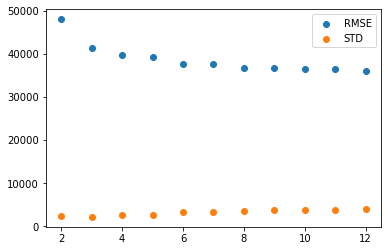

In [195]:
results = []
for i in range(2, 13):
    df = convert_df_simple(full_database, i)
#     df.info()
    result = [i]
    result.extend(rmse(df, print_result=False))
    results.append(result)
print(results)
plt.scatter([i[0] for i in results], [i[1] for i in results], label="RMSE")
plt.scatter([i[0] for i in results], [i[2] for i in results], label="STD")
plt.legend()
plt.show()

Selection of more than 8 features does not improve model's prediction error.

## Selection of best number and categorical features based on domain knowledge for linear regression
- remove columns that are too specific or irrelevant
- combine specific features into more generic ones

In [106]:
useless_cols = [
    "Order",
    "PID",
    "Lot Frontage",
    "Street",
    "Alley",
    "Lot Shape",
    "Land Contour",
    "Lot Config",
    "Land Slope",
    "Condition 2",
    "Roof Style",
    "Year Built",
    "Roof Matl",
    "Exterior 2nd",
    "Mas Vnr Type",
    "Mas Vnr Area",
    "Bsmt Qual",
    "Bsmt Exposure",
    "BsmtFin Type 1",
    "BsmtFin Type 2",
    "BsmtFin SF 2",
    "Bsmt Cond",
    "Bsmt Unf SF",
    "1st Flr SF",
    "2nd Flr SF",
    "Low Qual Fin SF",
    "BsmtFin SF 1",
    "Bedroom AbvGr",
    "Kitchen AbvGr",
    "TotRms AbvGrd",
    "Functional",
    "Year Remod/Add",
    "Fireplace Qu",
    "Garage Type",
    "Garage Yr Blt",
    "Garage Finish",
    "Garage Cars",
    "Garage Qual",
    "Misc Feature",
    "Misc Val",
    "Mo Sold",
    "Yr Sold",
    "Sale Type",
    "Sale Condition",
    "Fence",
    "Pool QC",
]

combines = {
    "external_resting_area_NEW": ["Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch"],
    "total_bathrooms_NEW": ["Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath"],
}

columns_to_string = [
    "MS SubClass",
]

to_fill_na = {
    "Garage Cond": "NA",
}

In [197]:
def convert_df_selected(df):
    """Convert dataframe dropping unnecessary columns,
    combining selected features into more generic ones
    and dropping NAs
    """
    final = df.copy()
    for key in combines:
        final[key] = final[combines[key]].sum(axis=1)
        final = final.drop(combines[key], axis=1)
    final["age_when_sold"] = final["Yr Sold"] - final["Year Remod/Add"]
    final = final.drop(final[final["age_when_sold"]<0].index)
    final = final.fillna(to_fill_na)
    final = final.drop(useless_cols, axis=1, errors="ignore")
    final = final.dropna() 
    final[columns_to_string] = final[columns_to_string].astype("object")
    return final

In [198]:
df = conver_df_selected(full_database)
df.info()
rmse(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2924 entries, 0 to 2929
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MS SubClass                2924 non-null   object 
 1   MS Zoning                  2924 non-null   object 
 2   Lot Area                   2924 non-null   int64  
 3   Utilities                  2924 non-null   object 
 4   Neighborhood               2924 non-null   object 
 5   Condition 1                2924 non-null   object 
 6   Bldg Type                  2924 non-null   object 
 7   House Style                2924 non-null   object 
 8   Overall Qual               2924 non-null   int64  
 9   Overall Cond               2924 non-null   int64  
 10  Exterior 1st               2924 non-null   object 
 11  Exter Qual                 2924 non-null   object 
 12  Exter Cond                 2924 non-null   object 
 13  Foundation                 2924 non-null   objec

(28328.941453918087, 3689.114059331888)

## Using features selected in previous step in Random Forrest model

In [206]:
def rmse_random_forest(df: pd.DataFrame) -> float:
    df = df.copy()
    df = pd.get_dummies(df)
    features = df.columns.drop(TARGET)
    model = RandomForestRegressor(max_depth=10)
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    rmses = []
    for train_i, test_i in kf.split(df):
        model.fit(df[features].iloc[train_i], df[TARGET].iloc[train_i])
        prediction = model.predict(df[features].iloc[test_i])
        rmse = np.sqrt(mean_squared_error(prediction, df[TARGET].iloc[test_i]))
        rmses.append(rmse)
    print(f"\nAvg root mean squared error: ${np.mean(rmses):,.0f}",
        f"std dev of rmses: ${np.std(rmses):,.0f}", sep="\n", )
    return np.mean(rmses)

In [207]:
df = prepare_selected(full_database)
a = rmse_random_forest(df)


Avg root mean squared error: $26,767
std dev of rmses: $4,041
